In [1]:
#数据处理
import numpy as np
import pandas as pd
#数据可视化
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# 使用r2_score作为回归模型性能的评价
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#显示中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = ['sans-serif']
#解决-变成方框问题
matplotlib.rcParams['axes.unicode_minus'] = False
#读取数据
dpath = "./Data/Test1/"
df = pd.read_csv(dpath + "FE_Advertising.csv")
#通过观察前5行，了解数据每列（特征）的概况
df.head()

,TV,radio,newspaper,sales
0,0.969852,0.981522,1.778945,22.1
1,-1.197376,1.082808,0.669579,10.4
2,-1.516155,1.528463,1.783549,9.3
3,0.052050,1.217855,1.286405,18.5
4,0.394182,-0.841614,1.281802,12.9


In [2]:
# 从原始数据中分离输入特征x和输出y
y = df['sales']
#用3维特征
#X = df.drop('sales', axis = 1)
#feat_names = X.columns
#只用1维特征
X = df['TV']
X = X.values.reshape(-1, 1)#reshape(-1,1)代表将二维数组重整为一个一列的二维数组
feat_names = ['TV']
#只用2维特征
#X = df.drop(['sales','newspaper'], axis = 1)
#特征名称，用于后续显示权重系数对应的特征
#feat_names = X.columns
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split
# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
#X_train.shape

In [3]:
# 1、线性回归
from sklearn.linear_model import LinearRegression
# 1.使用默认配置初始化学习器实例
lr = LinearRegression()
# 2.用训练数据训练模型参数
lr.fit(X_train, y_train)
# 3. 用训练好的模型对测试集进行预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)
#性能评估，R方分数
print("The r2 score of LinearRegression on test is %f" %(r2_score(y_test, y_test_pred_lr)))
print("The r2 score of LinearRegression on train is %f" %(r2_score(y_train, y_train_pred_lr)))
#性能评估，MSE
print("The MSE of LinearRegression on test is %f" %(mean_squared_error(y_test, y_test_pred_lr)))
print("The MSE of LinearRegression on train is %f" %(mean_squared_error(y_train, y_train_pred_lr)))
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((lr.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':lr.intercept_}], ignore_index=True)
fs
# 目标函数：L2损失
def obj_ols(X, y, w):
    N = X.shape[0] # 样本数目
    y_pred = np.dot(X, w)#Numpy中dot()函数主要功能有两个:向量点积和矩阵乘法
    res = y - y_pred
    return np.sum(res ** 2)/2/N # 目标函数

The r2 score of LinearRegression on test is 0.645722
The r2 score of LinearRegression on train is 0.601754
The MSE of LinearRegression on test is 7.740833
The MSE of LinearRegression on train is 11.226449


[0. 0.]
(256, 256)
(256,)


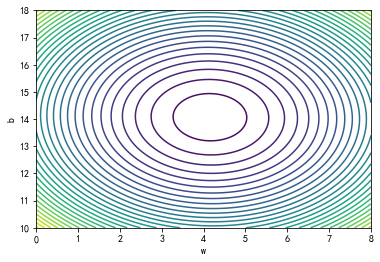

In [4]:
#L2损失函数的等高线
n = 256
w = np.linspace(0, 8, n) #numpy.linspace()函数用于在线性空间中以均匀步长生成数字序列
b = np.linspace(10, 18, n)
Js_grid = np.zeros((n, n))# 创建一个N*N的零矩阵
w_2d = np.zeros(2)
print(w_2d)
#y = wx+b
intercept = np.ones(X_train.shape[0])
X_train_new = np.c_[X_train,intercept]#np.c_()是将两个矩阵横着拼接,使列数增加
# 把w,b数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W, B = np.meshgrid(w, b)
print(W.shape)
print(b.shape)
for i in range(0,n):
    w_2d[0] = w[i]
    for j in range(0,n):
        w_2d[1] = b[j]
        Js_grid[i,j] = obj_ols(X_train_new, y_train, w_2d)
# 等高线
plt.contour(W, B, Js_grid, 30)
plt.xlabel(u'w')
plt.ylabel(u'b')
# 显示图表
plt.show()


In [5]:
# 2、梯度：目标函数的一阶导数
def grad_OLS(X, y, w):
    N = X.shape[0] # 样本数目
    X_transpose = np.transpose(X)#X的转置
    y_pred = np.dot(X, w)
    res = y_pred - y
    #(Xw-y)*X^T
    grad = np.dot(X_transpose , res)/N
    return grad
# 梯度下降法
# 给定起始点与目标函数的一阶导函数，求在epochs次迭代中x的更新值
def bgd_ols(X, y, w_start, df, max_epochs=10000, lr=0.1, epsilon = 0.0001):
    """
    :param X, y: 训练数据
    :param w_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param max_epochs: 最大迭代次数
    :param lr: 学习率
    :return: 每次迭代后的位置（包括起始点），和对应目标函数值
    """
    #初始化
    ws = [] # 参数
    Js = [] # 目标函数
    D = X.shape[1] # 列数，特征维度
    w = w_start
    row = []
    for j in range(D):
        row.append(w[j])
    ws.append(row)
    J = obj_ols(X, y,w)
    Js.append(J)
    for iter in range(1, max_epochs+1):
        dw = df(X, y, w) #计算梯度
        w += - dw * lr #根据梯度，更新参数
        row = []
        for j in range(D):
            row.append(w[j])
        ws.append(row)
        #判断目标函数是否收敛
        J = obj_ols(X, y,w)
        Js.append(J)
        #判断是否收敛
        if (abs(Js[iter-1]-J)/Js[iter-1] < epsilon or abs(Js[iter-1]-J)/Js[iter-1]< epsilon or Js[iter] <epsilon):
            break
    return ws, Js
n = 256
w = np.linspace(0, 8, n)
b = np.linspace(10, 18, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)
intercept = np.ones(X_train.shape[0])
X_train_new = np.c_[X_train,intercept]

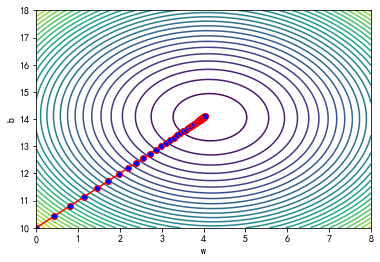

In [6]:
# 把w,b数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W, B = np.meshgrid(w, b)
#初始化
D = X_train_new.shape[1] # 特征维度
w_start = [0,10] #参数初始化
for i in range(0,n):
    w_2d[0] = w[i]
    for j in range(0,n):
        w_2d[1] = b[j]
        Js_grid[i,j] = obj_ols(X_train_new, y_train, w_2d)
# 等高线
plt.contour(W, B, Js_grid, 30)
#梯度下降
ws_bgd, Js_bgd = bgd_ols(X_train_new, y_train, w_start, grad_OLS, lr = 0.1)
ws_np_bgd = np.mat(ws_bgd) # 可将ws_bgd转化为矩阵
plt.plot(ws_np_bgd[:,0], ws_np_bgd[:,1], color='r',markerfacecolor='blue',marker='o')
plt.xlabel(u'w')
plt.ylabel(u'b')
# 显示图表
plt.show()